# Run 'stockread.py' once every weekday. 
## It may take up to an hour to download data 
## (depending on net speed)

In [ ]:
import sys
!python3 stockreader.py

Log file name : ./logs/log_2020-Mar-05-08-31-29.txt
Wait! Download in progress ... this may take a while
-- Downloading stocks list!
-- Done!
-- Downloading latest End of Day pricing data ...
-- Done!
-- Downloading fundamental company data ...


# Import stockdatalib

In [48]:
import stockdatalib as sd

# Must set the data subdirectory

In [49]:
# Set the data directory and the stock name
sd.set_data_directory('./data/')

# Load Data and plot a stock

In [50]:
# Load S&P Stock list
stock_count, stock_fields, sp_df = sd.GetSP500_List()

In [51]:
# Set stock symbol
mystock = 'MSFT'
sd.set_stock(mystock)

In [52]:
stock_info = sd.get_stock_info(mystock)
# Get stock company information
company_name = stock_info['name'][0]
company_sector = stock_info['sector'][0]
print(stock_info)

{'stock': ['msft'], 'name': ['Microsoft Corp.'], 'sector': ['Information Technology']}


In [53]:
# Get latest price quote
print(sd.quote(mystock))

  symbol                date   close    volume
0   MSFT 2020-03-04 14:30:00  170.55  49738100


In [54]:
# Get latest key stats on the stock
sd.key_stat(mystock)

,symbol,Date,No. of Shares,Revenue,Earning before Tax,PE Ratio,Earning per Share,Net Income,Free Cash Flow Margin,Gross Profit,Free Cash Flow per Share
0,MSFT,2019-12-31,7.628000e+09,3.690600e+10,1.408500e+10,25.9384,1.53,1.164900e+10,0.191161,2.454800e+10,0.675


<Figure size 1080x432 with 0 Axes>

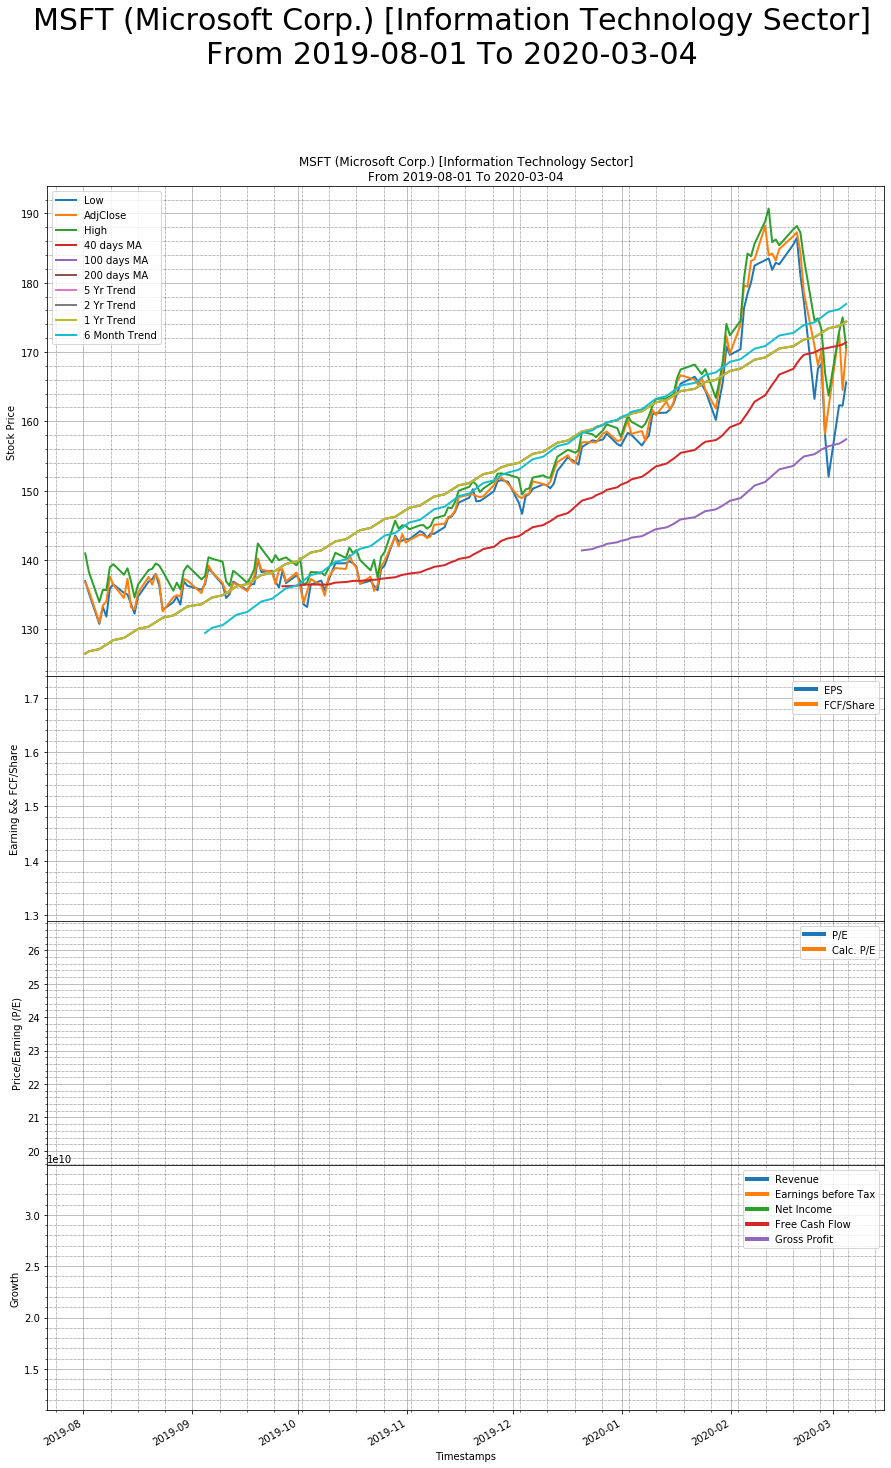

In [55]:
# Plot stock basic charts
price_df = sd.GetStockDataFrame(mystock)
price_df = sd.DatesRange(price_df, '2019-08-01') # limit the data since a specific past date or a range

linear_trends = sd.plot_basic_charts(mystock,price_df)

In [56]:
# Linear Regression Equations returned by the plot call
linear_trends

,5 Years Trend Line Function,2 Years Trend Line Function,1 Year Trend Line Function,6 Months Trend Line Function
0,0.3237 x + 126.5,0.3237 x + 126.5,0.3237 x + 126.5,0.3799 x + 129.4


In [57]:
# Get last price quote
sd.quote('csco')

,symbol,date,close,volume
0,csco,2020-03-04 14:30:00,41.39,30004000


In [58]:
# Get last key stats on the stock
sd.key_stat('ibm')

,symbol,Date,No. of Shares,Revenue,Earning before Tax,PE Ratio,Earning per Share,Net Income,Free Cash Flow Margin,Gross Profit,Free Cash Flow per Share
0,ibm,2019-09-30,887291199.0,1.802800e+10,1.522000e+09,16.7728,1.88,1.672000e+09,0.168127,8.335000e+09,3.597


,5 Years Trend Line Function,2 Years Trend Line Function,1 Year Trend Line Function,6 Months Trend Line Function
0,0.3237 x + 126.5,0.3237 x + 126.5,0.3237 x + 126.5,0.3799 x + 129.4


<Figure size 1080x432 with 0 Axes>

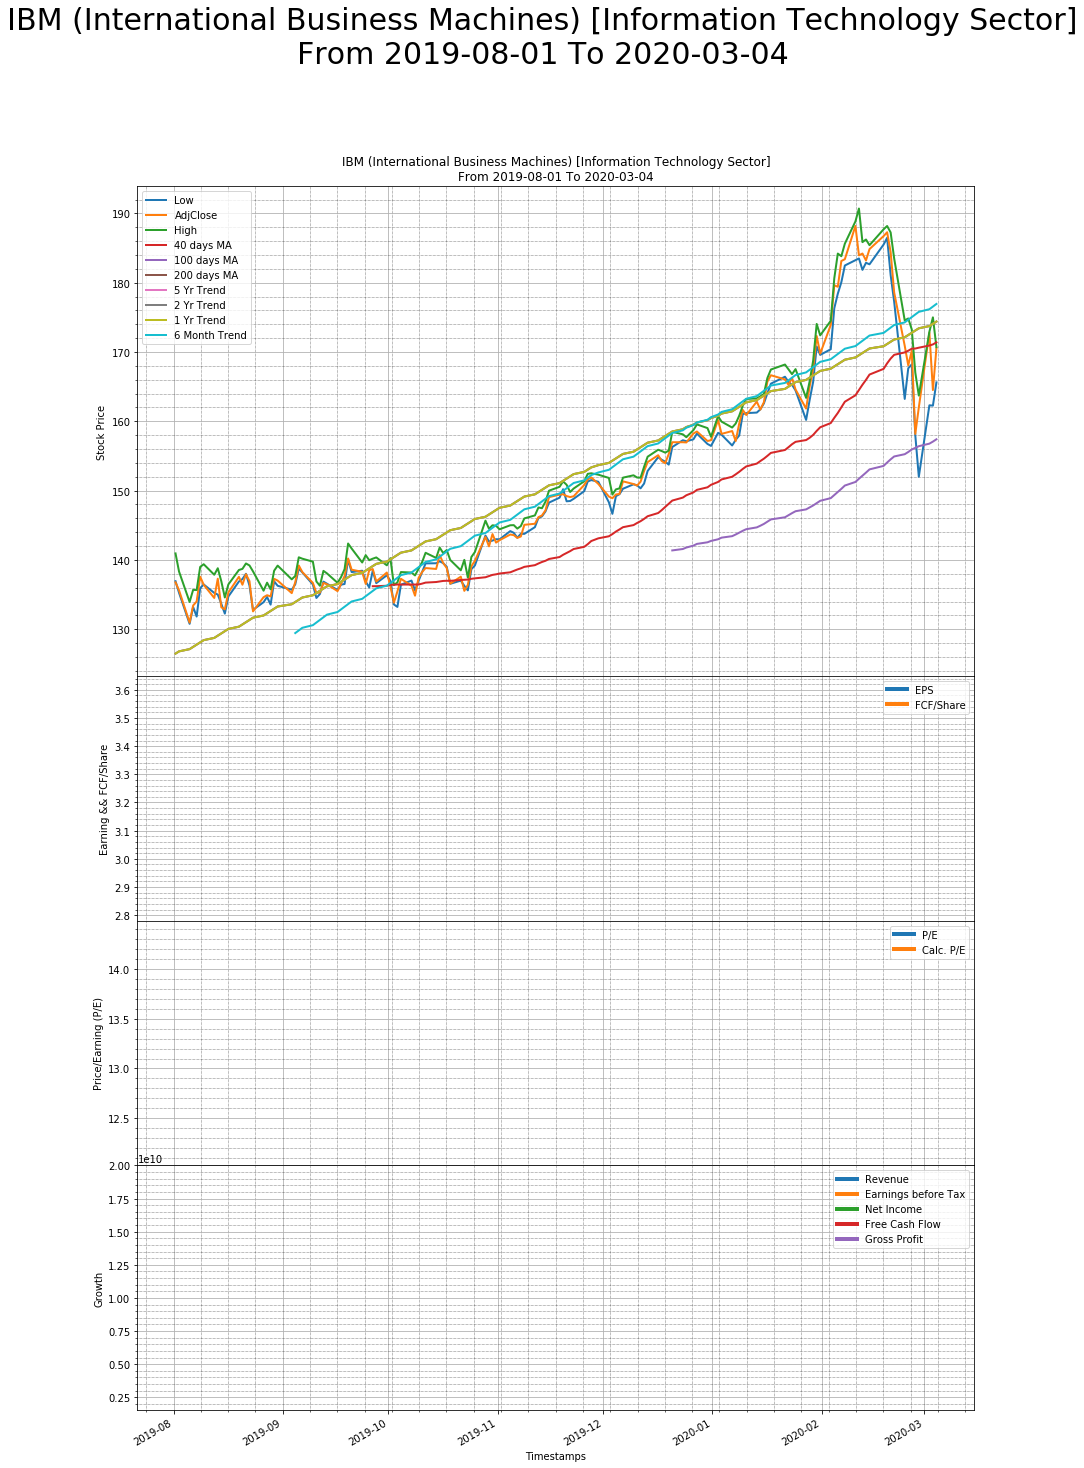

In [59]:
# Plot another stock
price_df_test = sd.DatesRange(price_df, '2019-06-01')
sd.plot_basic_charts(sd.get_stock(),price_df_test)

# The data load functions

In [60]:
# Load stock End of Day prices file
price_df = sd.GetStockDataFrame('msft')

# Load the stock fundamental data
keys, column_map, main_df_org = sd.GetFund_Dict('msft')

# Searching for data by column name

In [61]:
# Search for a key word in the data column names
table,text = sd.FindColumn('Revenue')
table

,column_name,DataFrame
0,Revenue,income-statement
1,Revenue Growth,income-statement
2,Cost of Revenue,income-statement
3,Deferred revenue,balance-sheet-statement
4,Revenue per Share,company-key-metrics
5,SG&A to Revenue,company-key-metrics
6,R&D to Revenue,company-key-metrics
7,Capex to Revenue,company-key-metrics
8,Stock-based compensation to Revenue,company-key-metrics
9,profitabilityIndicatorRatios_eBITperRevenue,financial-ratios


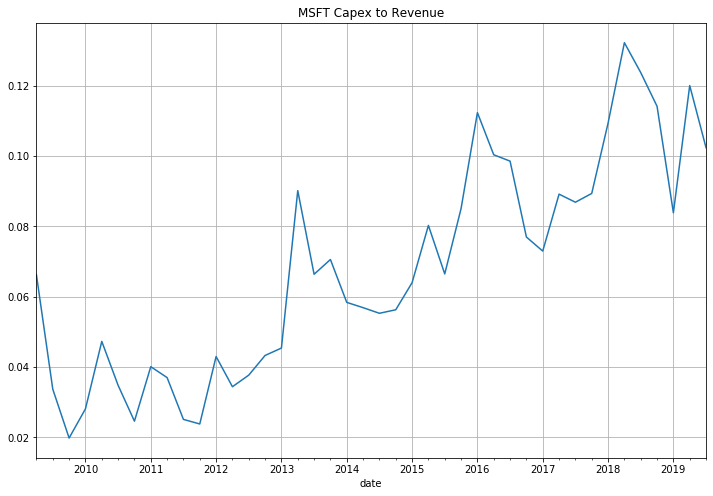

In [62]:
# Now we know where 'Capex to Revenue' is, we can load it from the DataFrame source 'company-key-metrics' as 
# the code below
main_df_org['company-key-metrics']['Capex to Revenue'].plot(figsize=(12,8),
                                                            grid=True, 
                                                            title=sd.get_stock().upper()+' Capex to Revenue')

# Selecting data range from price data frame

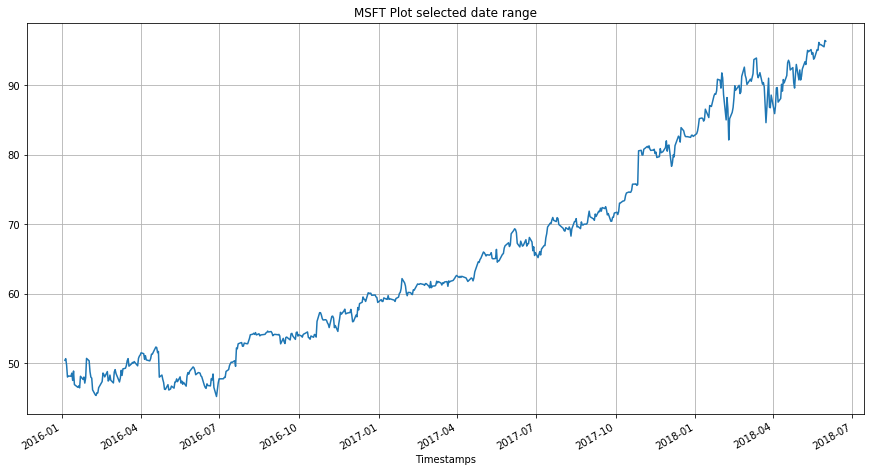

In [63]:
# Limit the stock prices data in the dates range
price_df = sd.DatesRange(price_df, '2016-01-01', '2018-06-01')

# Plot the prices chart
ax1 = price_df['AdjClose'].plot(figsize=(15,8),
                                title=sd.get_stock().upper()+" Plot selected date range").grid()

# Merging DataFrames from multiple sources into one DF

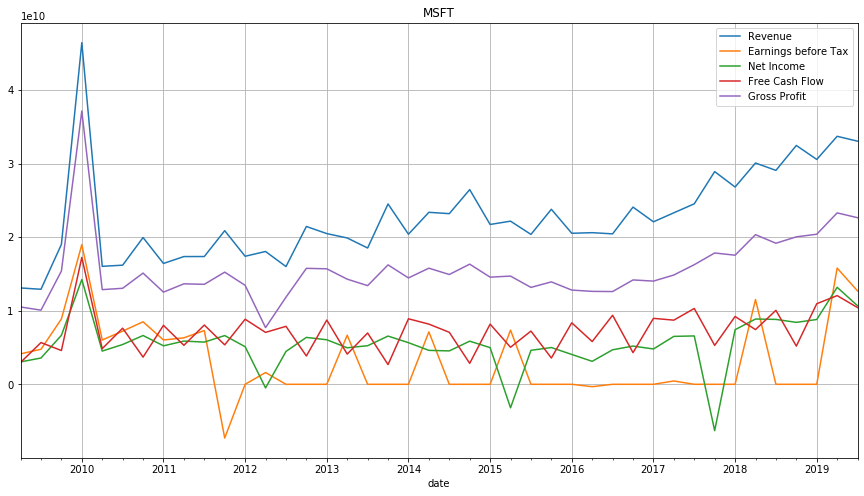

In [64]:
import pandas as pd

# Create a subset of columns in a DataFrame from the stock fundamentals dataset
cols = ['Revenue','Earnings before Tax','Net Income','Free Cash Flow margin','Gross Profit','Net Profit Margin'] # [ 'Shares', 'Price', 'Revenue', 'Earnings']
main_df1 = sd.MakeFund_Subset(main_df_org['income-statement'],cols)

# Create another subset of columns from another fundamentals dataset
cols = ['Number of Shares','Stock Price']
main_df2 = sd.MakeFund_Subset(main_df_org['enterprise-value'],cols)

# Create a 3rd subject of columns from yet another fundamentals dataset
cols = ['Capital Expenditure','Free Cash Flow']
main_df3 = sd.MakeFund_Subset(main_df_org['cash-flow-statement'],cols)

# Create a 4th subject of columns from yet another fundamentals dataset
cols = ['Free Cash Flow per Share']
main_df4 = sd.MakeFund_Subset(main_df_org['company-key-metrics'],cols)


# Merge the 3 dataframes into a single dataframe
main_df = pd.merge(main_df1,main_df2,on='date')
main_df = pd.merge(main_df,main_df3,on='date')
main_df = pd.merge(main_df,main_df4,on='date')

main_df.plot(y=['Revenue','Earnings before Tax','Net Income','Free Cash Flow','Gross Profit'],
             figsize=(15,8),title=sd.get_stock().upper()).grid()


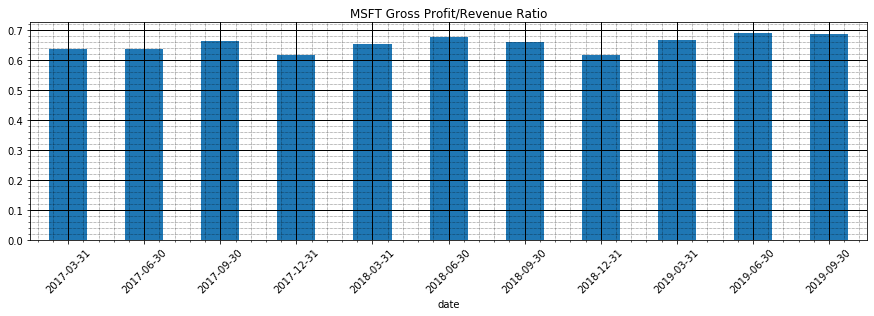

In [65]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

main_df = sd.DatesRange(main_df, '2017-01-01')
fig, ax = plt.subplots()
GrossOverRev_df = main_df['Gross Profit'] / main_df['Revenue']
ax = GrossOverRev_df.plot(ax=ax , kind='bar',
                          figsize=(15,4),
                          title=sd.get_stock().upper()+' Gross Profit/Revenue Ratio')

ax.xaxis.grid( which = 'minor')
ax.grid(True)

_=plt.xticks(rotation=45)

ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.xaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')
ax.yaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')

ticklabels = GrossOverRev_df.index.strftime('%Y-%m-%d')
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))


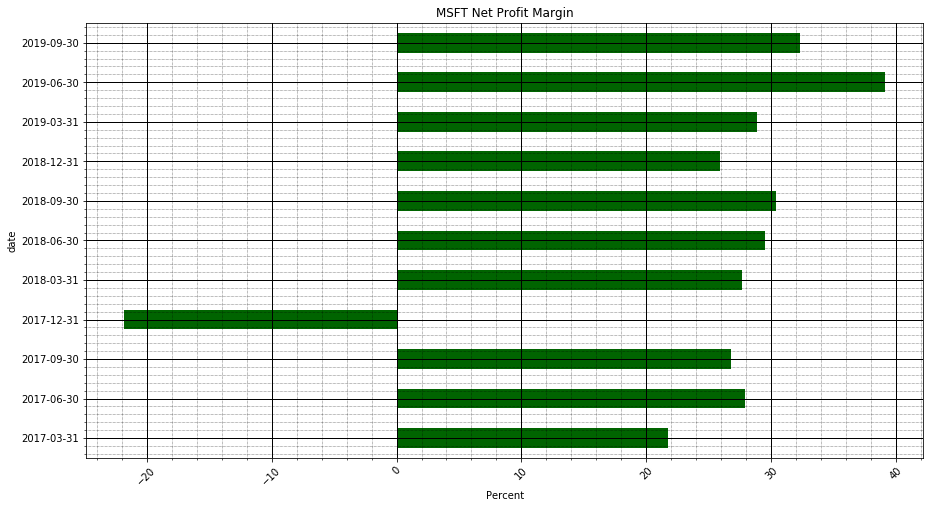

In [66]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots()
tmp_df = (main_df['Net Profit Margin'] * 100)
_=tmp_df.plot(ax=ax,y="Percent", kind='barh',figsize=(15,8),title=sd.get_stock().upper()+' Net Profit Margin',
              grid=True, color='darkgreen').set_xlabel('Percent')


ax.xaxis.grid( which = 'minor')
ax.grid(True)

_=plt.xticks(rotation=45)

ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.xaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')
ax.yaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')

ticklabels = tmp_df.index.strftime('%Y-%m-%d')
ax.yaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

# Using DatesRange() on fundamental data 

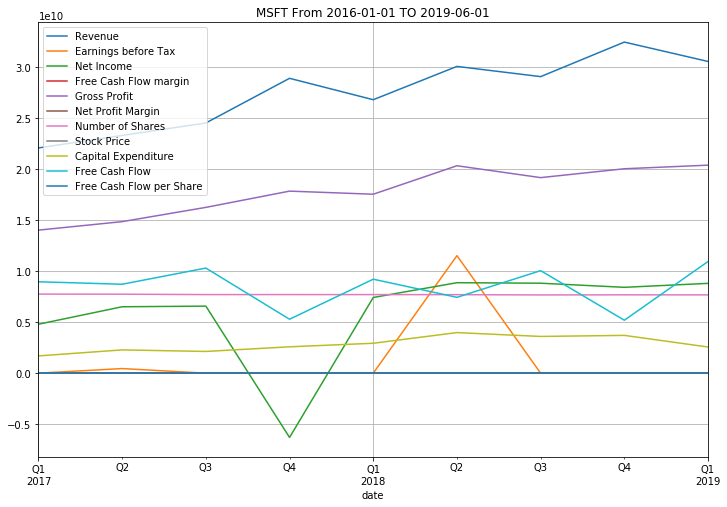

In [67]:
_=sd.DatesRange(main_df, '2016-01-01', '2019-06-01').plot(figsize=(12,8),
                                                                     grid=True,
                                                                     title=sd.get_stock().upper()+' From 2016-01-01 TO 2019-06-01')

<Figure size 1080x432 with 0 Axes>

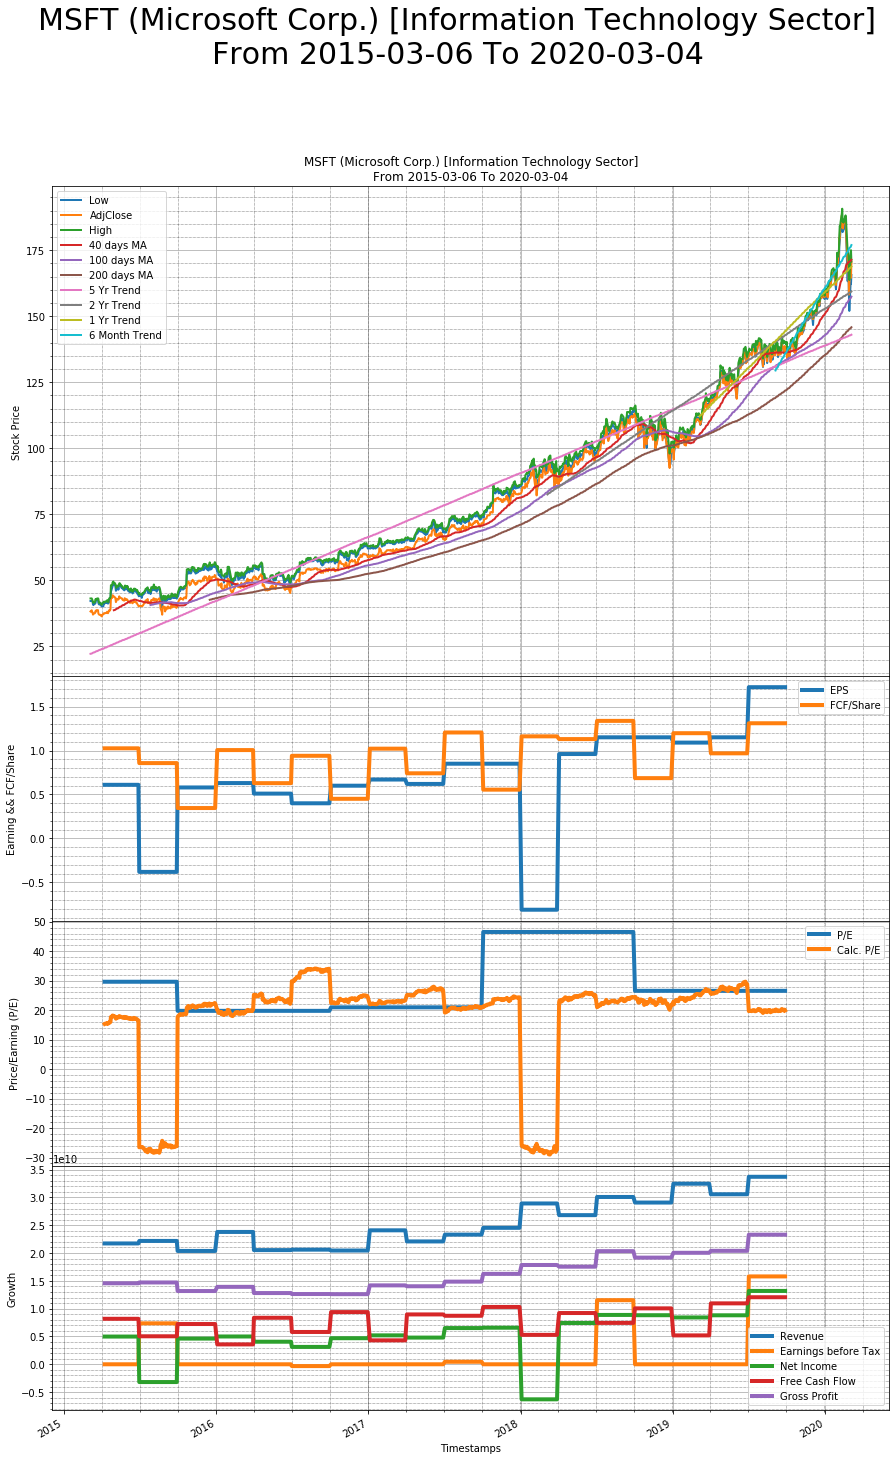

In [68]:
# Plot price chart with trend lines, EPS, and PE ratios
_=sd.plot_basic_charts('msft')

# Plot a single key stat item

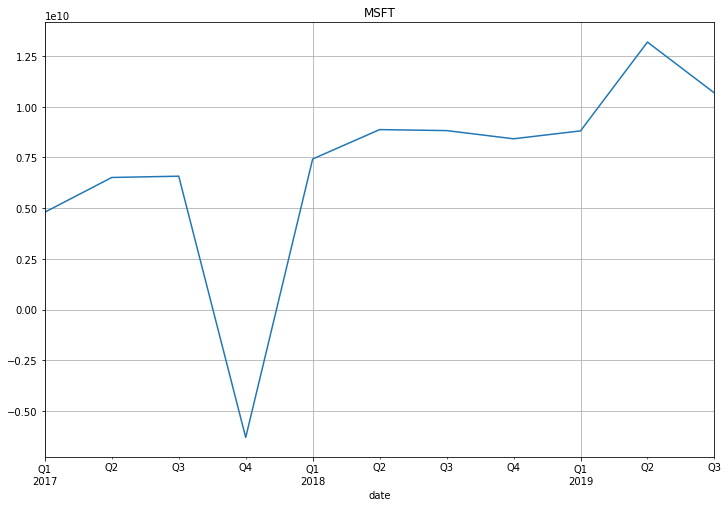

In [69]:
main_df['Net Income'].plot(figsize=(12,8), title = sd.get_stock().upper()).grid()

# Plot the TrendChart()

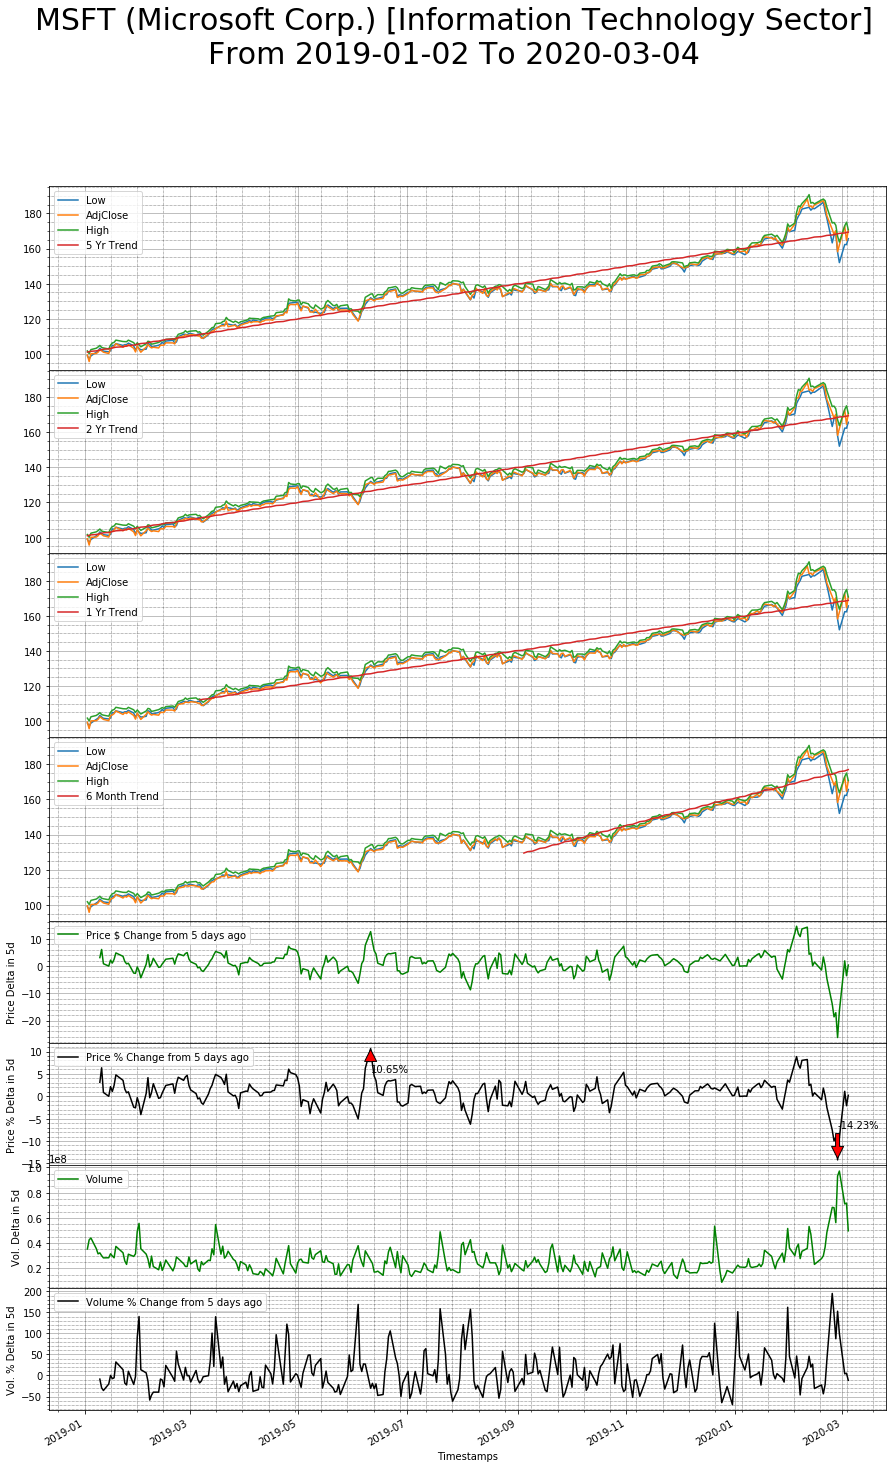

In [70]:
price_df = sd.GetStockDataFrame('msft')
price_df = sd.DatesRange(price_df, '2019-01-01')
price_data_df, maximums_table_df = sd.TrendsPlot('msft',price_df)

# Show the Maximums Table in price and volume

In [71]:
maximums_table_df

,Date,Price,Volume
Change Type,,,
Max % Rise,2019-06-10,10.65%,--
Max % Drop,2020-02-27,-14.23%,--
Max % Rise,2020-02-24,--,195.09%
Max % Drop,2019-12-30,--,-69.43%


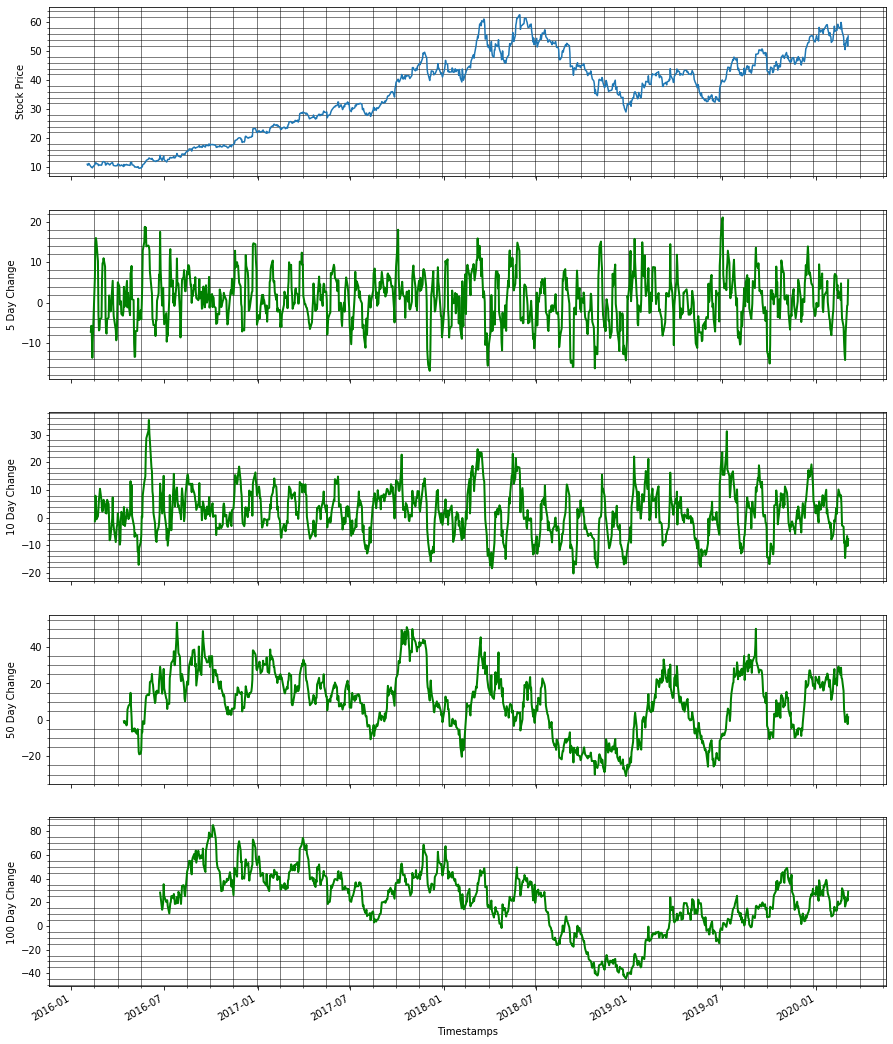

,5,10,20,30,40,50,60,80,100,200,Directions 5,Directions 10,Directions 20,Directions 30,Directions 40,Directions 50,Directions 60,Directions 80,Directions 100,Directions 200
count,1025.000000,1020.000000,1010.000000,1000.000000,990.000000,980.000000,970.000000,950.000000,930.000000,830.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,0.965842,1.987323,4.016068,6.010653,8.084732,10.206528,12.367901,16.835888,21.143255,45.129232,0.129756,0.177561,0.163902,0.288780,0.380488,0.427317,0.491707,0.565854,0.561951,0.413659
std,6.216329,8.600713,11.955514,14.322805,15.933949,17.446929,19.321425,22.634899,25.732511,50.038328,0.992030,0.982107,0.979509,0.945033,0.906578,0.879917,0.839794,0.779250,0.769484,0.799541
min,-16.961494,-20.252194,-24.555741,-28.239363,-34.006094,-30.855374,-35.496778,-44.009262,-44.501817,-48.453608,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-2.924193,-3.480852,-4.751300,-3.673756,-2.977207,-1.628162,0.707912,4.225307,6.045168,1.610296,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.060251,1.632939,3.014052,5.191284,8.576538,12.055530,13.531997,19.332914,23.410057,48.178149,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,4.930355,7.514455,12.166449,16.567310,18.824656,22.423492,25.535942,32.401509,39.390018,86.142154,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,21.175025,35.367115,46.919077,55.203044,46.691933,53.451877,59.003272,80.268597,85.146443,164.426055,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
import pandas as pd

price_df = sd.GetStockDataFrame('mu')
price_df = sd.DatesRange(price_df, '2016-02-01')
periods = [5,10,20,30,40,50,60,80,100,200]
price_changes = pd.DataFrame(columns = periods+['Timestamps'])
updownlist = []

fig, ax = plt.subplots(5,1, figsize=(15,20), sharex=True)

for axx in ax:
    axx.xaxis.grid( which = 'minor')
    axx.yaxis.grid( which = 'minor')
    axx.grid(True)

    _=plt.xticks(rotation=45)
    axx.minorticks_on()

    axx.grid(which='minor', linestyle='-', linewidth='0.5', color='black')
    axx.xaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')
    axx.yaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')


for i in periods:    
    price_changes[i] = (price_df['AdjClose'].pct_change(i) * 100  ).dropna().copy(deep=True)

    updownlist = list()   
    for n in price_changes[i]:
        if n >= 0:
            updownlist.append(1)
        elif n < 0:
            updownlist.append(-1)
        else:
            updownlist.append(0)
    
    price_changes['Directions '+str(i)] = updownlist
    
    
price_df['AdjClose'].plot(ax=ax[0])    
ax[0].set_ylabel('Stock Price')


price_changes[5].plot(ax=ax[1], color='green', lw=2.0)
ax[1].set_ylabel('5 Day Change')

price_changes[10].plot(ax=ax[2], color='green', lw=2.0)
ax[2].set_ylabel('10 Day Change')

price_changes[50].plot(ax=ax[3], color='green', lw=2.0)
ax[3].set_ylabel('50 Day Change')


price_changes[100].plot(ax=ax[4], color='green', lw=2.0)
ax[4].set_ylabel('100 Day Change')

plt.show()    

price_changes.describe()

Mean = 21.14%
Std. Div. = 25.73%
Variance = 662.16%


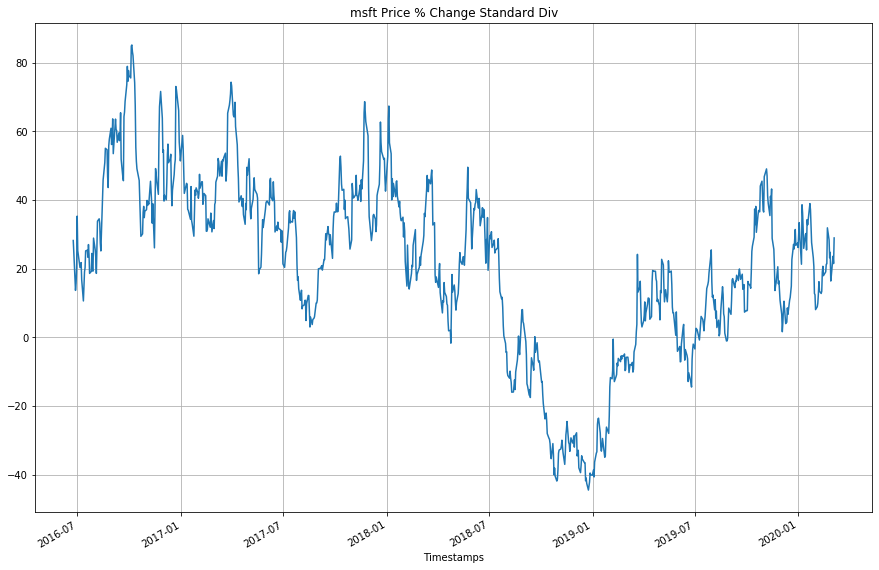

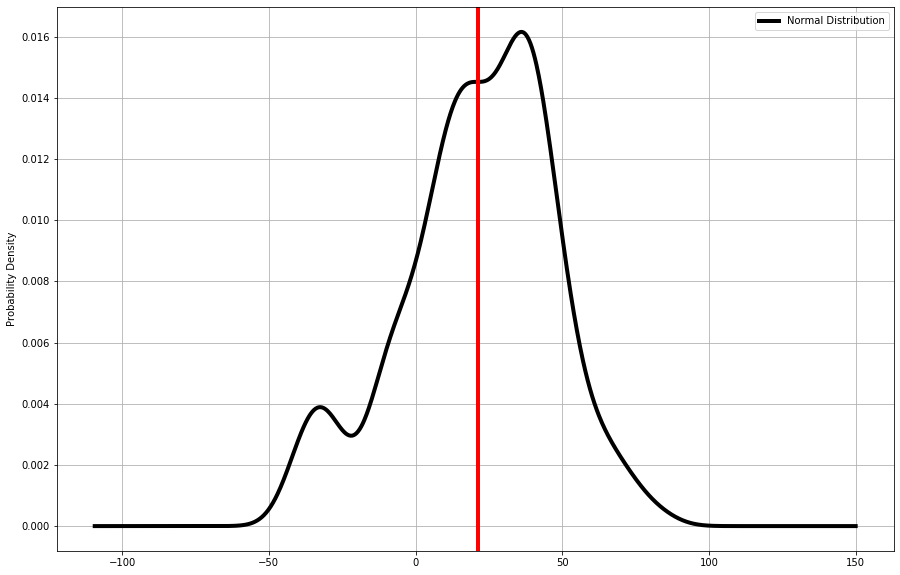

In [73]:
price_changes100 = price_changes[100]
price_changes100.plot(figsize=(15,10),title=sd.get_stock()+' Price % Change Standard Div').grid()

test_df = pd.DataFrame({'Normal Distribution':price_changes100.tolist()})
ax = test_df.plot(kind='kde',color='black', lw=4, grid=True,figsize=(15,10))

ax.set_ylabel('Probability Density')
ax.axvline(x = price_changes100.mean(),linewidth=4, color='r')
print("Mean = "+str(round(price_changes100.mean(),2))+ "%")
print("Std. Div. = "+str(round(price_changes100.std(),2))+ "%")
print("Variance = "+str(round(price_changes100.var(),2))+ "%")

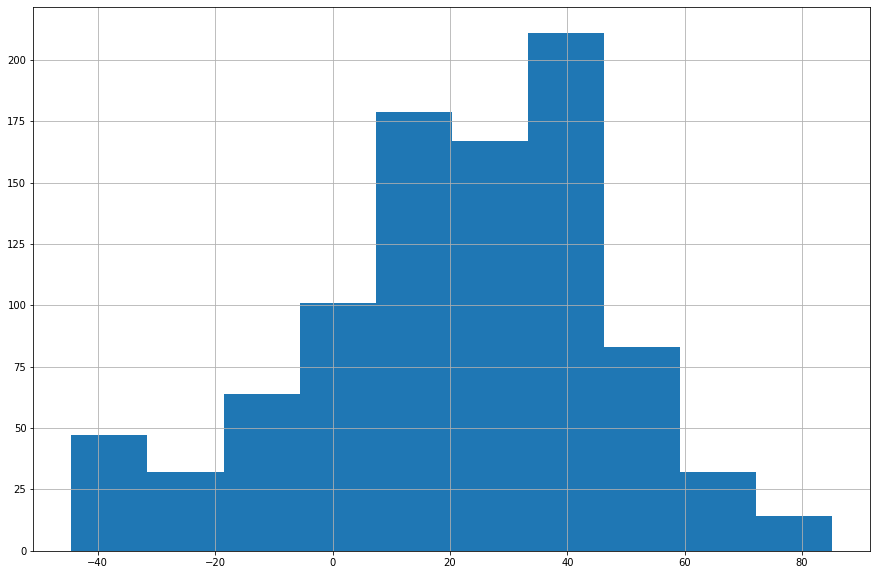

In [74]:
price_changes100.hist(figsize=(15,10))

# Search for a column containing 'cash flow' substring

In [75]:
f,s = sd.FindColumn('cash flow')
f

,column_name,DataFrame
0,Free Cash Flow margin,income-statement
1,Operating Cash Flow,cash-flow-statement
2,Investing Cash flow,cash-flow-statement
3,Financing Cash Flow,cash-flow-statement
4,Net cash flow / Change in cash,cash-flow-statement
5,Free Cash Flow,cash-flow-statement
6,Operating Cash Flow per Share,company-key-metrics
7,Free Cash Flow per Share,company-key-metrics
8,EV to Operating cash flow,company-key-metrics
9,EV to Free cash flow,company-key-metrics


In [76]:
fcfy_df = main_df_org['company-key-metrics']['Free Cash Flow Yield']

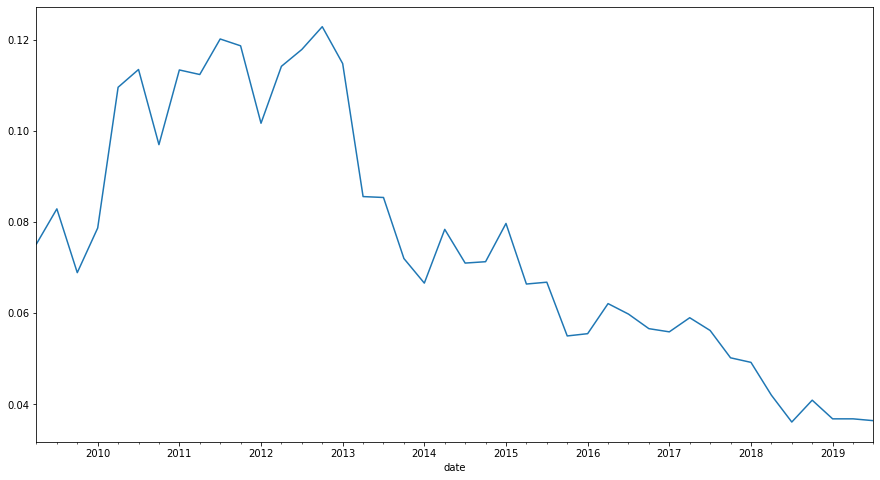

In [77]:
fcfy_df.plot(figsize=(15,8))

In [106]:
import time
def print_over(txt):
    print('\r',end='')
    print(txt,end='')
    
r,c,stocks = sd.GetSP500_List()
for s in stocks['Symbol']:
    print_over(s)
    time.sleep(0.1)
    


ZTSNL

In [107]:
r,c,stocks = sd.GetSP500_List()
stocks
for s in stocks['Symbol']:
    print_over(s)

ZTS